# Live Tweet Analysis

In [83]:
# Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

import warnings
warnings.filterwarnings('ignore')

import tweepy
from tweepy import OAuthHandler

import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [104]:
# Assign the credentials

consumer_key = "Your Consumer Key"
consumer_secret = "Your Consumer Secret"
access_token = "Your Access Token"
access_token_secret = "Your Access Secret"


# Authenticate the API using above credentials

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [85]:
# Create a Dataframe to store the extracted data.

df = pd.DataFrame(columns=["Date","User","Tweet",'User_location'])
print(df)

Empty DataFrame
Columns: [Date, User, Tweet, User_location]
Index: []


In [86]:
# Function to collect tweets


def get_tweets(topic, location_id, Count):    
    i=0
    for tweet in tweepy.Cursor(api.search, q='{} place:{}'.format(topic, location_id), lang="en", exclude='retweets').items():
        print(i, end='\r')
        df.loc[i,"Date"] = tweet.created_at
        df.loc[i,"User"] = tweet.user.name
        df.loc[i,"Tweet"] = tweet.text
        df.loc[i,"User_location"] = tweet.user.location
        i=i+1
        if i>Count:
            break
        else:
            pass
        

In [87]:
# Call the function to collect the tweets according to the given location, topic and count
location = api.geo_search(query="India", granularity="country")
location_id = location[0].id
topic=["Covid19"]
get_tweets(topic, location_id, Count=100)

In [88]:
# First 10 tweets
df.head(10)

,Date,User,Tweet,User_location
0,2021-04-17 16:43:28,Dr Varun Vij,Horrendous death rate !! Hair raising positivi...,"New Delhi, India"
1,2021-04-17 16:40:57,Praveen Sharma,👹 #COVID19 India Data 👹\n\nThis is the daily C...,"Gurugram, India"
2,2021-04-17 16:38:35,Kallol Bhattacherjee,@KalidasuGirid Covid19 is a rarity - a tantasi...,Delhi
3,2021-04-17 16:38:22,M_ibrahim,No political party or Political Leader is abov...,"Goa, India"
4,2021-04-17 16:38:07,amiya agarwal,@drharshvardhan @PMOIndia #Covid19 15 Apr 2020...,"Pitampura, New Delhi"
5,2021-04-17 16:37:21,Sanjay Bragta,Another records Corona cases in Delhi in a row...,"New Delhi, India"
6,2021-04-17 16:36:53,Ayadoure Srinivasane Stalin,It is very painful to learn that Shri. @nazeem...,"New Delhi, India"
7,2021-04-17 16:32:01,Avneesh Gautam,The traffic (the lack of it) is the absolute h...,"New Delhi, India"
8,2021-04-17 16:31:50,Sagar Kapoor,Please note this is only for the needy!!! Peop...,India
9,2021-04-17 16:30:56,Sanjay Bragta,"PM directed close coordination with States, en...","New Delhi, India"


# Tweet Processing

In [89]:
# Function to clean the tweets

stop_words = set(stopwords.words('english')) # Set of stopwords (Words that doesn't give meaningful information)

lemmatizer = WordNetLemmatizer()  # Used for converting words with similar meaning to a single word.

def text_process(tweet):

    processed_tweet = [] # To store processed text

    tweet = tweet.lower() # Convert to lower case

    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', 'URL', tweet) # Replaces any URLs with the word URL

    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet) # Replace @handle with the word USER_MENTION

    tweet = re.sub(r'#(\S+)', r' \1 ', tweet) # Removes # from hashtag

    tweet = re.sub(r'\brt\b', '', tweet) # Remove RT (retweet)

    tweet = re.sub(r'\.{2,}', ' ', tweet) # Replace 2+ dots with space

    tweet = tweet.strip(' "\'') # Strip space, " and ' from tweet

    tweet = re.sub(r'\s+', ' ', tweet) # Replace multiple spaces with a single space

    words = tweet.split()

    for word in words:

        word = word.strip('\'"?!,.():;') # Remove Punctuations

        word = re.sub(r'(.)\1+', r'\1\1', word) # Convert more than 2 letter repetitions to 2 letter (happppy -> happy)

        word = re.sub(r'(-|\')', '', word) # Remove - & '

        if (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None): # Check if the word starts with an english letter

            if(word not in stop_words):                                 # Check if the word is a stopword.

                word = str(lemmatizer.lemmatize(word))                  # Lemmatize the word

                processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [90]:
# Function to analyze sentiment

def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'


In [91]:
# Function to clean tweets

df['clean_tweet'] = df['Tweet'].apply(lambda x : text_process(x))
df.head()

,Date,User,Tweet,User_location,clean_tweet
0,2021-04-17 16:43:28,Dr Varun Vij,Horrendous death rate !! Hair raising positivi...,"New Delhi, India",horrendous death rate hair raising positivity ...
1,2021-04-17 16:40:57,Praveen Sharma,👹 #COVID19 India Data 👹\n\nThis is the daily C...,"Gurugram, India",covid19 india data daily corona case data indi...
2,2021-04-17 16:38:35,Kallol Bhattacherjee,@KalidasuGirid Covid19 is a rarity - a tantasi...,Delhi,USER_MENTION covid19 rarity tantasing peril de...
3,2021-04-17 16:38:22,M_ibrahim,No political party or Political Leader is abov...,"Goa, India",political party political leader much politici...
4,2021-04-17 16:38:07,amiya agarwal,@drharshvardhan @PMOIndia #Covid19 15 Apr 2020...,"Pitampura, New Delhi",USER_MENTION USER_MENTION covid19 apr point ex...


In [92]:
# Function to analyse the sentiments

df["Sentiment"] = df["Tweet"].apply(lambda x : analyze_sentiment(x))
df.head(5)

,Date,User,Tweet,User_location,clean_tweet,Sentiment
0,2021-04-17 16:43:28,Dr Varun Vij,Horrendous death rate !! Hair raising positivi...,"New Delhi, India",horrendous death rate hair raising positivity ...,Neutral
1,2021-04-17 16:40:57,Praveen Sharma,👹 #COVID19 India Data 👹\n\nThis is the daily C...,"Gurugram, India",covid19 india data daily corona case data indi...,Neutral
2,2021-04-17 16:38:35,Kallol Bhattacherjee,@KalidasuGirid Covid19 is a rarity - a tantasi...,Delhi,USER_MENTION covid19 rarity tantasing peril de...,Neutral
3,2021-04-17 16:38:22,M_ibrahim,No political party or Political Leader is abov...,"Goa, India",political party political leader much politici...,Positive
4,2021-04-17 16:38:07,amiya agarwal,@drharshvardhan @PMOIndia #Covid19 15 Apr 2020...,"Pitampura, New Delhi",USER_MENTION USER_MENTION covid19 apr point ex...,Neutral


In [102]:
# Check the Summary of a random record
n = randrange(100)
print("Original tweet:\n",df['Tweet'][n])
print()
print("Clean tweet:\n",df['clean_tweet'][n])
print()
print("Sentiment of the tweet:\n",df['Sentiment'][n])

Original tweet:
 It’s far easy to make children understand! But what about adults ?? What about #ElectionCampaign ? What about… https://t.co/6OZFOFnLsy

Clean tweet:
 far easy make child understand adult electioncampaign URL

Sentiment of the tweet:
 Positive


In [94]:
# Overall Summary

print("Total Tweets Extracted for Topic : {} are : {}".format(Topic,len(df.Tweet)))
print("Total Positive Tweets are : {}".format(len(df[df["Sentiment"]=="Positive"])))
print("Total Negative Tweets are : {}".format(len(df[df["Sentiment"]=="Negative"])))
print("Total Neutral Tweets are : {}".format(len(df[df["Sentiment"]=="Neutral"])))

Total Tweets Extracted for Topic : ['Covid19'] are : 101
Total Positive Tweets are : 40
Total Negative Tweets are : 18
Total Neutral Tweets are : 43


In [95]:
df["Sentiment"].value_counts()

Neutral     43
Positive    40
Negative    18
Name: Sentiment, dtype: int64

# Visualisation

Text(0.5, 1.0, 'Summary of Counts for Total tweets')

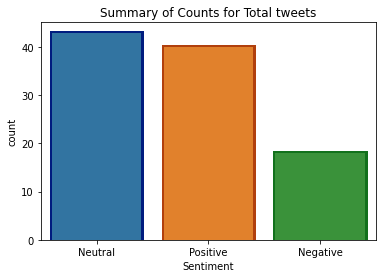

In [96]:
#Create a Bargraph for the sentiments of tweets 

sns.countplot(df["Sentiment"],facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
sns.countplot(df["Sentiment"])
plt.title("Summary of Counts for Total tweets")


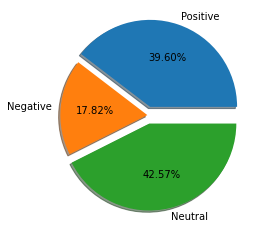

In [100]:
# Piechart 

a=len(df[df["Sentiment"]=="Positive"])
b=len(df[df["Sentiment"]=="Negative"])
c=len(df[df["Sentiment"]=="Neutral"])
d=np.array([a,b,c])
explode = (0.1, 0.0, 0.1) #Used to break the piechart
plt.pie(d,shadow=True,explode=explode,labels=["Positive","Negative","Neutral"],autopct='%1.2f%%');

# Generate WordCloud

There are 7611 words in the combination of all review.


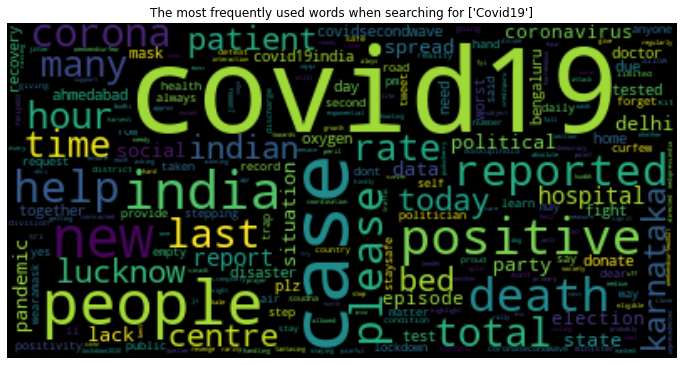

In [101]:
# Combine all individual sentences into a single text and create a WordCloud to see the common words in these tweets.

text = " ".join(review for review in df.clean_tweet)
print("There are {} words in the combination of all review.".format(len(text)))


# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["USER_MENTION","URL"])  #To add any custom StopWords


# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,collocations=False, max_words=800,max_font_size=70).generate(text)

# Create the wordcloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("The most frequently used words when searching for {}".format(Topic))
plt.axis("off")
plt.show()